In [1]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

# Math Stuff
import ee, scipy.misc, random, os
import numpy as np
from threading import Thread

# debug stuff
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [2]:
# https://indico.io/blog/tensorflow-data-inputs-part1-placeholders-protobufs-queues/

# Machine Learning

In [3]:
import tensorflow as tf


from scipy import misc

def gee_batch(data_label_file, batch_size):
    """Generates batches of size `batch_size`"""
    
    # read file
    lines = open(data_label_file).read().splitlines()
    
    img_list = []
    label_list = []
    for i in range(batch_size):
        png_path, label = random.choice(lines).split(',')
        
        img = misc.imread(png_path)
        processed_img = img[:,:,0]
        small_img = scipy.misc.imresize(processed_img, (50,50))
#         three_d_img = np.expand_dims(small_img, axis=2)
        img_list.append(small_img.flatten() / 255.0)

        one_hot = np.zeros(3)
        one_hot[int(label)] = 1
        label_list.append(one_hot)
        
    return np.stack(img_list, axis=0), np.stack(label_list, axis=0)

In [4]:
#
# Create protobuf
#

DATA_DIR="./ch3_data"
TRAIN_IMG_DIR=os.path.join(DATA_DIR, "train_imgs")
TRAIN_IMG_LABELS=os.path.join(DATA_DIR, "train.txt")
TEST_IMG_DIR=os.path.join(DATA_DIR, "test_imgs")
TEST_IMG_LABELS=os.path.join(DATA_DIR, "test.txt")

PROTO_FILENAME = "gee_test.tfrecords"

# # Open a protobuffer writer
# proto_writer = tf.python_io.TFRecordWriter(PROTO_FILENAME)

# # Iterate over every exmaple and put it in the protobuffer
# for line in open(TEST_IMG_LABELS).read().splitlines():
#     png_path, label = line.split(',')
#     img = misc.imread(png_path).flatten()
    
#     proto_example = tf.train.Example(
#         features=tf.train.Features( # a map of string to Feature proto objects
#             feature={
#                 # A Feature contains one of either a int64_list,
#                 # float_list, or bytes_list
#                 'label': tf.train.Feature(
#                     int64_list=tf.train.Int64List(value=[int(label)])),
#                 'image': tf.train.Feature(
#                     int64_list=tf.train.Int64List(value=img.astype("int64")))
#             }
#         )
#     )
    
#     # use the proto object to serialize the example to a string
#     serialized = proto_example.SerializeToString()
#     # write the serialized object to disk
#     proto_writer.write(serialized)


0


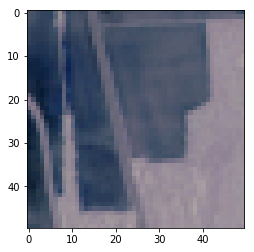

0


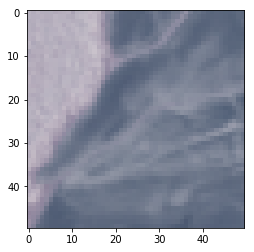

0


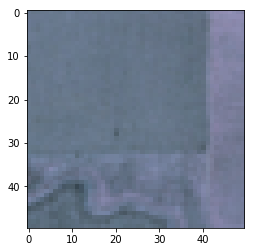

In [5]:
#
# Look inside protobuff to make sure records are correctly recorded.
#

PROTO_FILENAME = "gee_test.tfrecords"

i = 0
for serialized_example in tf.python_io.tf_record_iterator(PROTO_FILENAME):
    i = i + 1
    if i > 3:
        break
    example = tf.train.Example()
    example.ParseFromString(serialized_example)

    # traverse the Example format to get data
    image = example.features.feature['image'].int64_list.value
    label = example.features.feature['label'].int64_list.value[0]
    # do something
    print label

    img = np.array(image).astype("float32")

    plt.imshow(img.reshape((50,50, 3)), cmap='gray'); plt.show()


In [6]:
#
# Required input placeholders
#
training = tf.placeholder(dtype=tf.bool, name="is_training") # True if training, False if testing
batch_size = tf.placeholder(dtype=tf.int32, name="batch_size")

#
# Our data-loading pipeline
#

def get_batch(proto_filename, batch_size):
    filename_queue = tf.train.string_input_producer([proto_filename], num_epochs=None)
    proto_reader = tf.TFRecordReader()

    # Examples from the protobuf.
    # TODO: what is the first returned value?
    _, serialized_example = proto_reader.read(filename_queue)

    # The serialized example is converted back to actual values
    # by describing the format of the objects to be returned
    features = tf.parse_single_example(
        serialized_example,
        features={
            # We know the length of both fields. If not the
            # tf.VarLenFeature could be used
            'label': tf.FixedLenFeature([], tf.int64),
            'image': tf.FixedLenFeature([50*50*3], tf.int64)
        })

    # now we have the raw data
    label = features['label']
    image = features['image']

    # wrest the data into the desired orientation
    cast_img = tf.cast(image, tf.float32)
    threeD_img = tf.reshape(cast_img, [50,50, 3])
    bw_img = tf.slice(threeD_img, [0, 0, 0], [50, 50, 1])
    oneD_img = tf.reshape(bw_img, [50*50])
    squashed_img = tf.divide(oneD_img, 255)

    # and batch it
    images_batch, labels_batch = tf.train.shuffle_batch(
        [squashed_img, label], batch_size=batch_size,
        capacity=2000,
        min_after_dequeue=1000)

    return images_batch, labels_batch


#
# Load the correct training/test data
#

TRAIN_PROTO_FILENAME = "gee_train_large.tfrecords"
TEST_PROTO_FILENAME = "gee_test_large.tfrecords"

train_images_batch, train_labels_batch = get_batch(TRAIN_PROTO_FILENAME, batch_size)
test_images_batch, test_labels_batch = get_batch(TEST_PROTO_FILENAME, batch_size)

images_batch, labels_batch = tf.cond(training,
                         lambda: (train_images_batch, train_labels_batch),
                         lambda: (test_images_batch, test_labels_batch)
                        )


#
# Model
#


x = images_batch
y_ = images_batch


# input_norm = tf.contrib.layers.batch_norm(x, 
#                                   center=True, scale=True, 
#                                   is_training=training)



# Ensure our images are the correct shape
input_layer = tf.reshape(x, [-1, 50, 50, 1])


#
# Convolutions
#

# Convolutional Layer #1
conv1 = tf.layers.conv2d(
    inputs=input_layer,
    filters=16,
    kernel_size=[3, 3],
    strides = [1,1],
    padding="valid",
    activation=tf.nn.relu)
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

# Convolutional Layer #2
conv2 = tf.layers.conv2d(
    inputs=pool1,
    filters=16,
    kernel_size=[3, 3],
    strides = [1,1],
    padding="valid",
    activation=tf.nn.relu)
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

# Convolutional Layer #3
conv3 = tf.layers.conv2d(
    inputs=pool2,
    filters=16,
    kernel_size=[4, 4],
    strides = [1,1],
    padding="valid",
    activation=tf.nn.relu)
pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)

# Dense Layer
conv3_flat = tf.reshape(pool3, [-1, 4 * 4 * 16])
fc1 = tf.layers.dense(inputs=conv3_flat, units=256, activation=tf.nn.relu)

fc2 = tf.layers.dense(inputs=fc1, units=256, activation=tf.nn.relu)

fc3 = tf.layers.dense(inputs=fc2, units=50*50, activation=tf.nn.relu)


#
# Loss
#

loss = None
train_op = None
y_pred = fc3
y_true = y_

loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))

# fc_activations = layerOutputs.append(fc2)


In [7]:
#
# Train
#
from IPython.display import clear_output


global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 1e-3
learning_rate = tf.train.exponential_decay(learning_rate = starter_learning_rate,
                                           global_step = global_step,
                                           decay_steps = 200,
                                           decay_rate = 0.96,
                                           staircase=True)


update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS) # batch norm
with tf.control_dependencies(update_ops): # batch norm
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)


# Initialize tensorflow
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# start the data reader tensors
tf.train.start_queue_runners(sess=sess)

# And run 10k iterations
for i in range(30000):
    
    # Debug output
    if i%100 == 1:
        prediction, loss_out = sess.run( fetches = [y_pred, loss],
                                         feed_dict={training: False, batch_size:256})
        print i, ":", loss_out
    
    # run an iteration
    optimizer.run(feed_dict={training: True, batch_size:256})



1 : 0.175033
101 : 0.0571011
201 : 0.0504367
301 : 0.035653
401 : 0.0240581
501 : 0.0189736
601 : 0.0156828
701 : 0.0135593
801 : 0.0129823
901 : 0.0112328
1001 : 0.0112942
1101 : 0.0114494
1201 : 0.0109815
1301 : 0.0110746
1401 : 0.0101668
1501 : 0.00925667
1601 : 0.0109895
1701 : 0.00946263
1801 : 0.00994613
1901 : 0.0102728
2001 : 0.0094149
2101 : 0.0093602
2201 : 0.00900181
2301 : 0.00850189
2401 : 0.00971664
2501 : 0.00921458
2601 : 0.00886871
2701 : 0.00985154
2801 : 0.00830128
2901 : 0.00875625
3001 : 0.00877757
3101 : 0.00820572
3201 : 0.00902871
3301 : 0.00883073
3401 : 0.00758778
3501 : 0.0087969
3601 : 0.00856438
3701 : 0.00801892
3801 : 0.00883436
3901 : 0.00838103
4001 : 0.00854858
4101 : 0.00898529
4201 : 0.00811084
4301 : 0.00865706
4401 : 0.0085482
4501 : 0.00786451
4601 : 0.00854223
4701 : 0.00769272
4801 : 0.00771767
4901 : 0.00902515
5001 : 0.00823082
5101 : 0.00825543
5201 : 0.00854971
5301 : 0.00815653
5401 : 0.00874333
5501 : 0.00850561
5601 : 0.00737766
5701 : 0.

KeyboardInterrupt: 

Prediction difference: 0.00439398
Silly difference:      0.00792647819969


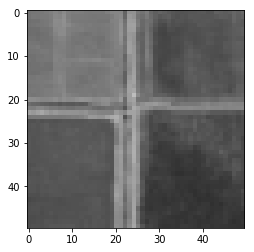

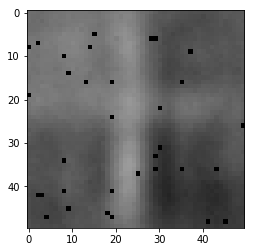

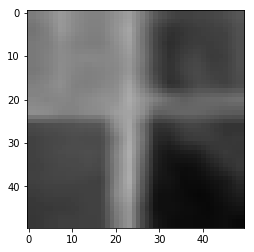

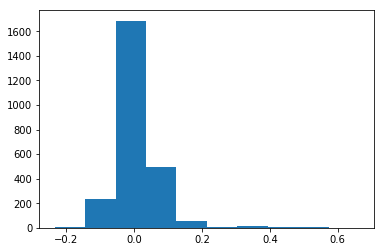

In [15]:
# Prediction

# farm, city, mountain


img_in, prediction, loss_out, feature_vector = sess.run( fetches = [y_true,y_pred, loss, fc2],
                                         feed_dict={training: False, batch_size:1})

img_in = img_in.reshape((50,50))
prediction = prediction.reshape((50,50))

silly_img = scipy.misc.imresize(scipy.misc.imresize(img_in, (16,16)), (50,50)) / 255.0
diff_img = img_in - prediction


print "Prediction difference:", np.mean(np.square(img_in - prediction))
print "Silly difference:     ", np.mean(np.square(img_in - silly_img))

plt.imshow(img_in, cmap='gray', vmin=0, vmax=1); plt.show()
plt.imshow(prediction, cmap='gray', vmin=0, vmax=1); plt.show()
plt.imshow(silly_img, cmap='gray', vmin=0, vmax=1); plt.show()
plt.hist(diff_img.flatten()); plt.show()

In [ ]:
#
# Clustering
#

from pylab import plot,show
from numpy import vstack,array
from numpy.random import rand
from scipy.cluster.vq import kmeans,vq
from scipy.spatial import distance

def featurize_image():
    img, feature_vector = sess.run( fetches = [y_true, fc2], feed_dict={training: False, batch_size:1})
    return img, feature_vector


#
# Calculate Error
#
def cluster_error(data, centroids, idx):
    sum_error = 0
    for i in range(idx.shape[0]):
        error = dst = distance.euclidean(data[i, :], centroids[idx[i], :])
        sum_error += error
    return sum_error
        
        
#
# Collect Data
#
data_img_list = []

for i in range(500):
    img, feature_vector = featurize_image()
    sample = {
        'img': img,
        'feature_vector': feature_vector
    }
    data_img_list.append(sample)

data = np.squeeze(np.array([d['feature_vector'] for d in data_img_list]))
   


# #
# # Mean Shift
# #
# from sklearn.cluster import MeanShift, estimate_bandwidth

# # The following bandwidth can be automatically detected using
# bandwidth = estimate_bandwidth(data, quantile=0.2, n_samples=100)
# print bandwidth
    
    
# ms = MeanShift(bandwidth=0.5, bin_seeding=True)
# ms.fit(data)
# labels = ms.labels_
# cluster_centers = ms.cluster_centers_

# labels_unique = np.unique(labels)
# n_clusters_ = len(labels_unique)

# print("number of estimated clusters : %d" % n_clusters_)


    
# #
# # K Means
# #

# k_list = []
# error_list = []

# for k in range(2,20):
#     centroids,_ = kmeans(data,k)
#     # assign each sample to a cluster
#     idx,_ = vq(data,centroids)

#     error = cluster_error(data, centroids, idx)
#     print "k=", k, ":", error
#     k_list.append(k)
#     error_list.append(cluster_error(data, centroids, idx))
    
# plt.plot(k_list, error_list, '-o')
# plt.show()
    
    
    
K=5
centroids,_ = kmeans(data,K)
# assign each sample to a cluster
idx,_ = vq(data,centroids)



for k in range(K):
    p = 1
    print "Cluster", k
    
    # collect images in class
    class_images = [data_img_list[i]
                    for i in range(idx.shape[0])
                    if idx[i] == k]
    
    # sort the image list based on each image's distance from the cluster center
    class_images.sort(
        key=lambda i_data: distance.euclidean(i_data['feature_vector'], centroids[k])
    )
    
    for image_data in class_images:
        if p <= 4*5:
            plt.subplot(4, 5, p)
            plt.axis('off')    
            plt.imshow(image_data['img'].reshape((50,50)), cmap='gray')
            p += 1
    plt.show()
    
